In [1]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

# car parameters
car_l = 4.3
car_w = 1.8


# car corners
base_corners = np.array([
    [ car_l / 2, -car_w / 2, 0], # front right
    [-car_l / 2, -car_w / 2, 0], # rear right
    [-car_l / 2,  car_w / 2, 0],  # rear left
    [ car_l / 2,  car_w / 2, 0], # front left
])

def plot_car(pos):
    rotated_corners = R.from_euler('xyz', [0,0,pos[2]]).apply(base_corners)
    rotated_corners += pos[:]

    plt.plot(rotated_corners[:, 0], rotated_corners[:, 1])
    plt.plot(pos[0], pos[1], 'ro')

def set_eq():
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.grid()

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


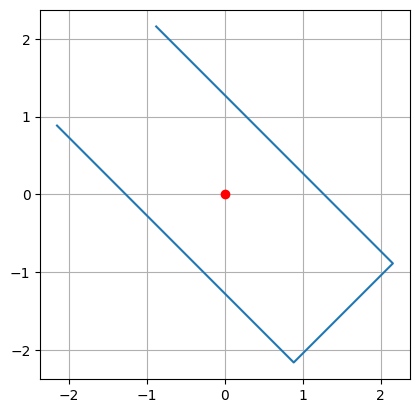

In [2]:
plot_car([0, 0, 3.141 * 3 / 4])
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.grid()

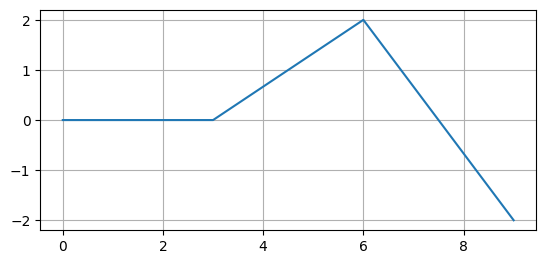

In [3]:
base_trajectory = np.array([
            [0, 0],
            [3, 0],
            [6, 2],
            [9, -2],
        #     [12, -2],
        #     [14, 0]
        ])
set_eq()
plt.plot(base_trajectory[:, 0], base_trajectory[:, 1])

(37, 2)


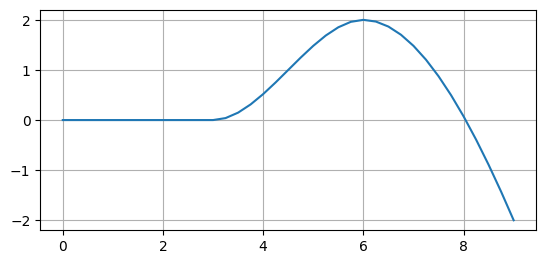

In [4]:
from scipy.interpolate import pchip_interpolate

dx = 0.5
trajectory_len = np.sum(np.linalg.norm(base_trajectory, axis=1))
interp_steps = int(trajectory_len / dx)

t_param = base_trajectory.shape[0]
base_t = np.arange(0, t_param)
interp_t = np.linspace(0, t_param-1, interp_steps)

interp_x = pchip_interpolate(base_t, base_trajectory[:, 0], interp_t)
interp_y = pchip_interpolate(base_t, base_trajectory[:, 1], interp_t)
smooth_traj = np.stack((interp_x, interp_y), axis=1)

print(smooth_traj.shape)
# plt.plot(base_trajectory[:, 0], base_trajectory[:, 1])
plt.plot(smooth_traj[:, 0], smooth_traj[:, 1])
set_eq()


In [5]:
def extract_angles_from_traj(trajectory_points):
    angles = np.zeros((trajectory_points.shape[0]), dtype=np.float32)
    for angle_idx in range(trajectory_points.shape[0] - 1):
        cur_p = trajectory_points[angle_idx]
        next_p = trajectory_points[angle_idx+1]
        derivative_vector = next_p - cur_p
        angles[angle_idx] = np.atan2(derivative_vector[1], derivative_vector[0])

    angles[-1] = angles[-2]
    return angles

angles = extract_angles_from_traj(smooth_traj)
angles = np.array([angles]).T
print(angles.shape)
print(smooth_traj.shape)
new_traj = np.hstack((smooth_traj, angles))

(37, 1)
(37, 2)


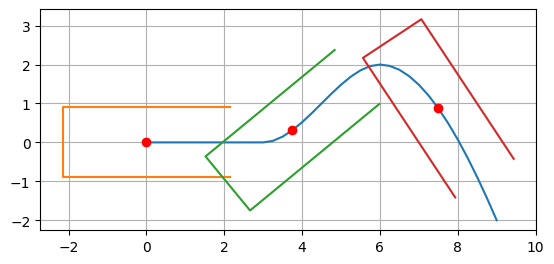

In [13]:
set_eq()

step = 15
plt.plot(new_traj[:, 0], new_traj[:, 1])
for i in range(0, new_traj.shape[0], step):
    plot_car(new_traj[i])

### Using smoothing in controller
I will have a smoothed trajectory.
Based on desired velocity, i will interpolate it even further

33


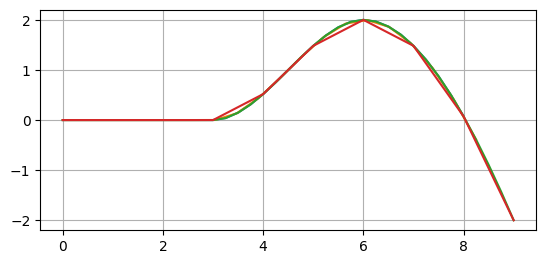

In [7]:
n_steps = 20
dt = 0.1
desired_vel = 5

traj = new_traj[:, :2]
diffs = new_traj[1:] - new_traj[:-1]
d_lengths = np.linalg.norm(diffs[:, :2], axis=1)

last_point = 0
acc_dist = 0
while acc_dist < n_steps * dt * desired_vel and last_point < d_lengths.shape[0]:
    acc_dist += d_lengths[last_point]
    last_point += 1

set_eq()
print(last_point)
new_x = np.linspace(traj[0, 0], traj[last_point, 0], n_steps)
new_y = pchip_interpolate(traj[:last_point, 0], traj[:last_point, 1], new_x)
plt.plot(traj[:last_point, 0], traj[:last_point, 1])
plt.plot(new_x, new_y)
plt.plot(traj[:, 0], traj[:, 1])

# downscale experiments
down_x = np.linspace(traj[0, 0], traj[-1, 0], int(n_steps / 2))
down_y = pchip_interpolate(traj[:, 0], traj[:, 1], down_x)
plt.plot(down_x, down_y)

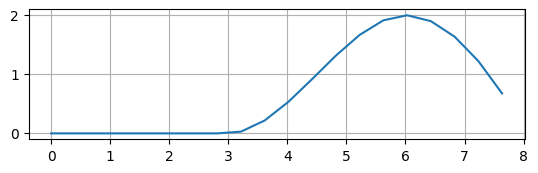

In [8]:
n_steps = 20
dt = 0.1
desired_velocity = 5

def set_target_trajectory(trajectory_2d):
    # calculate target distance for mpc prediction
    target_distance = n_steps * dt * desired_velocity

    # select points that are around target distance
    found_distance = 0
    last_point = 0
    while found_distance <= target_distance and last_point < trajectory_2d.shape[0]-1:
        last_point += 1
        found_distance += np.linalg.norm(trajectory_2d[last_point] - trajectory_2d[last_point-1])

    # find diff between desired and found
    distance_diff = found_distance - target_distance

    # find new point where trajectory will be split
    last_segment_vec = trajectory_2d[last_point] - trajectory_2d[last_point - 1]
    last_segment_len = np.linalg.norm(last_segment_vec)

    # find new segment len
    new_segment_len = last_segment_len - distance_diff
    new_segment_vec = last_segment_vec / last_segment_len * new_segment_len

    # calculate new point
    new_point = trajectory_2d[last_point - 1] + new_segment_vec
    
    # create dx for interpolation
    dx = (new_point - trajectory_2d[0])[0] / n_steps
    
    # interpolate coordinates
    new_x = np.arange(trajectory_2d[0, 0], trajectory_2d[-1, 0], dx)
    new_y = pchip_interpolate(trajectory_2d[:, 0], trajectory_2d[:, 1], new_x)
    
    return np.stack((new_x, new_y), axis=1)

    

traj = set_target_trajectory(base_trajectory)
set_eq()
plt.plot(traj[:20, 0], traj[:20, 1])

[[ 0.00000000e+00  0.00000000e+00]
 [ 4.34210526e-01  0.00000000e+00]
 [ 8.68421053e-01  0.00000000e+00]
 [ 1.30263158e+00  0.00000000e+00]
 [ 1.73684211e+00  0.00000000e+00]
 [ 2.17105263e+00  0.00000000e+00]
 [ 2.60526316e+00  0.00000000e+00]
 [ 3.03947368e+00  1.41997133e-03]
 [ 3.47368421e+00  1.34325605e-01]
 [ 3.90789474e+00  4.38717861e-01]
 [ 4.34210526e+00  8.42517255e-01]
 [ 4.77631579e+00  1.27301003e+00]
 [ 5.21052632e+00  1.65783906e+00]
 [ 5.64473684e+00  1.92430769e+00]
 [ 6.07894737e+00  1.99541019e+00]
 [ 6.51315789e+00  1.85907489e+00]
 [ 6.94736842e+00  1.53257354e+00]
 [ 7.38157895e+00  1.03728533e+00]
 [ 7.81710972e+00  3.87961766e-01]
 [ 8.20310680e+00 -3.03460096e-01]]


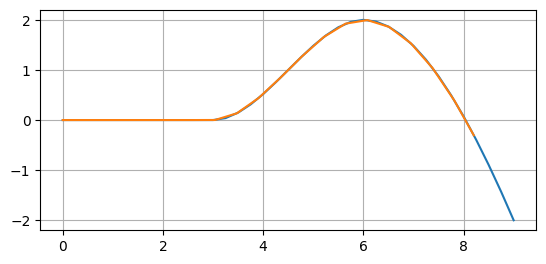

In [9]:
def create_immediate_trajectory(trajectory_2d):
    # calculate target distance for mpc prediction
    target_distance = n_steps * dt * desired_velocity

    # select points that are around target distance
    found_distance = 0
    last_point = 0
    while found_distance <= target_distance and last_point < trajectory_2d.shape[0]-1:
        last_point += 1
        found_distance += np.linalg.norm(trajectory_2d[last_point] - trajectory_2d[last_point-1])

    # find diff between desired and found
    distance_diff = found_distance - target_distance

    # find new point where trajectory will be split
    last_segment_vec = trajectory_2d[last_point] - trajectory_2d[last_point - 1]
    last_segment_len = np.linalg.norm(last_segment_vec)

    # find new segment len
    new_segment_len = last_segment_len - distance_diff
    new_segment_vec = last_segment_vec / last_segment_len * new_segment_len

    # calculate new point
    new_point = np.array([trajectory_2d[last_point - 1] + new_segment_vec])

    # immediate segment
    immediate_segment = np.vstack((trajectory_2d[:last_point], new_point))

    # create base t 
    base_t = np.arange(0, immediate_segment.shape[0])

    # create new t for interp
    new_t = np.linspace(0, base_t[-1], n_steps)

    # interpolate coordinates
    new_x = pchip_interpolate(base_t, immediate_segment[:, 0], new_t)
    new_y = pchip_interpolate(base_t, immediate_segment[:, 1], new_t)
    print(np.stack((new_x, new_y), axis=1)) 
    return np.stack((new_x, new_y), axis=1)

huh = create_immediate_trajectory(smooth_traj)
set_eq()
plt.plot(smooth_traj[:, 0], smooth_traj[:, 1])
plt.plot(huh[:, 0], huh[:, 1])

In [10]:
a = np.ones((4, 2, 2))
b = np.array(
    [
        [-1, 1],
        [-2, 2]
    ]
)
(a*b).reshape((8, 2))

array([[-1.,  1.],
       [-2.,  2.],
       [-1.,  1.],
       [-2.,  2.],
       [-1.,  1.],
       [-2.,  2.],
       [-1.,  1.],
       [-2.,  2.]])

KeyError: 'planned'

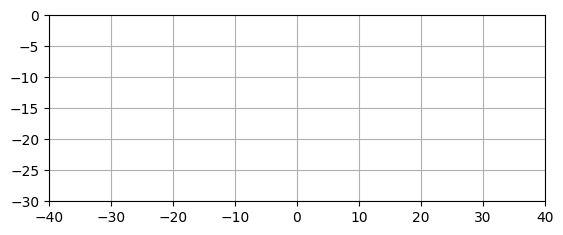

In [11]:
import pickle
import glob
set_eq()
plt.grid()

trajectories = glob.glob('trajectories/*pkl')
trajectories = sorted(trajectories)
cutoff = 20
target_cutoff = -1

xll = -40
xlr = 40
ylb = -30
ylt = -0

for traj_file in trajectories[:]:
    set_eq()
    plt.xlim(xll, xlr)
    plt.ylim(ylb, ylt)
    with open(traj_file, 'rb') as in_file:
        data = pickle.load(in_file)
        target = data['planned']
        real = data['real'][0]
        real_cost = data['real_cost']
        my_traj = data['my_control'][0]
        my_cost = data['my_cost']
        print('my cost: ', my_cost)
        print('real cost: ', real_cost)
        plt.plot(target[:target_cutoff, 0], target[:target_cutoff, 1], 'b--')
        plt.plot(real[:cutoff, 0], real[:cutoff, 1], 'g', linewidth=5)
        plt.plot(my_traj[:cutoff, 0], my_traj[:cutoff, 1], 'r-')
        plt.legend(['target', 'real', 'my'])

    